In [47]:
import warnings
warnings.filterwarnings("ignore") #holamundo

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

In [2]:
# rentabilidad = pd.read_csv('/kaggle/input/datathon/RentabilidadProduct.csv',sep='|')
# submit_example = pd.read_csv('/kaggle/input/datathon/submit_example.csv')
# data = pd.read_csv('/kaggle/input/datathon/train.csv',sep='|')

rentabilidad=pd.read_csv('RentabilidadProduct.csv', sep='|')
submit_example=pd.read_csv('submission_all.csv', sep='|')
data= pd.read_csv('train.csv', sep='|')

print('data', data.shape)
print('rentabilidad',rentabilidad.shape)
print('submit_example',submit_example.shape)

data (2167848, 9)
rentabilidad (937, 6)
submit_example (15312, 1)


In [3]:
data.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211
3,2022-01-31,9382,512,BO,21,V,1.0,0.153431,0.005211
4,2022-01-31,9382,525,BO,21,V,1.0,0.153431,0.005790


In [4]:
rentabilidad.head()

,product_id,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,881,1291,20,131,4,10.378017
1,805,1224,20,131,3,10.177925
2,892,1089,20,146,1,10.008243
3,841,1224,20,131,3,7.698362
4,830,1089,20,131,1,7.353678


In [5]:
df=data.merge(rentabilidad, on='product_id', how='inner')
df['fecha_compra']= pd.to_datetime(df['fecha_compra'], format = '%Y-%m-%d', errors = 'coerce')
# df['y']=(df.cantidad_venta*df.monto_venta_transf)
df.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,0.062530,1427,20,173,2,-0.306416
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,0.062530,1427,20,173,2,-0.306416


In [6]:
from datetime import timedelta
import pandas as pd
d=df.fecha_compra.min()+timedelta(days=-1)
list_dates=[]
semana_dates=[]
i=1
for y in range(0,60):
    for x in range(0,7):
        d=d+timedelta(days=1)
        a='semana'+str(i)
        semana_dates.append(a)
        list_dates.append(d)
    i=i+1
calendar=pd.DataFrame()
calendar['semana_dates'] = semana_dates
calendar['list_dates'] = list_dates

In [7]:
dtf_products=df.merge(calendar, left_on='fecha_compra', right_on='list_dates', how='inner')

t=pd.DataFrame(dtf_products.utilidad_bruta_transf)
mm_scaler = preprocessing.MinMaxScaler()
utilidad_bruta_transf_mm = mm_scaler.fit_transform(t)
utilidad_bruta_transf_mm = pd.DataFrame(utilidad_bruta_transf_mm)
dtf_products['utilidad_bruta_transf_mm']=utilidad_bruta_transf_mm

In [8]:
dtf_products['semana_dates']='semana0'

In [9]:
dtf_products['utilidad_bruta_transf_mm'].isnull().sum()

0

In [10]:
df2=dtf_products.groupby(['semana_dates', 'customer_id','product_id','tier_id','family_id','negocio_id','category_id']).agg({
         'monto_venta_transf':sum,    # 
         'cantidad_venta': sum,  # 
         'peso_venta_transf': sum,  # 
         'fecha_compra': "count",  #
         'utilidad_bruta_transf_mm': "median"  #
    }).reset_index()
df2.rename(columns={'fecha_compra':'frequencia'},inplace=True)

In [11]:
# ---------------------------------------
# Construcción de Data Set [User - Item]
# ---------------------------------------

# Base de datos suma de monto y trx total por cliente:
copy = pd.DataFrame()
copy = df2.copy()
tempMontoTot = pd.DataFrame()
tempMontoTot['montoTot'] = copy.groupby(['customer_id', 'semana_dates']).agg('monto_venta_transf').sum()
tempMontoTot['trxTot'] = copy.groupby(['customer_id','semana_dates']).agg('frequencia').sum()
#agregado sandy***************************************************************
tempMontoTot['cantTot'] = copy.groupby(['customer_id', 'semana_dates']).agg('cantidad_venta').sum()
tempMontoTot['pesoTot'] = copy.groupby(['customer_id','semana_dates']).agg('peso_venta_transf').sum()
tempMontoTot['renTot'] = copy.groupby(['customer_id','semana_dates']).agg('utilidad_bruta_transf_mm').sum()
#agregado sandy***************************************************************
tempMontoTot = tempMontoTot.reset_index()
tempMontoTot.head()

,customer_id,semana_dates,montoTot,trxTot,cantTot,pesoTot,renTot
0,1,semana0,4215.025943,768,3033.0,457.310962,29.333093
1,2,semana0,490.966092,77,410.0,54.047783,9.497980
2,3,semana0,635.393427,155,892.0,56.425377,11.057373
3,4,semana0,462.436700,48,312.0,39.745743,5.411344
4,5,semana0,1506.377974,302,954.0,188.512556,31.381974


In [12]:
# Base de datos suma de monto y trx total por cliente y comercio:
copy = pd.DataFrame()
copy = df2.copy()
tempMontoProducto = pd.DataFrame() 
tempMontoProducto['montoProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('monto_venta_transf').sum()
tempMontoProducto['trxProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('frequencia').sum()
#agregado sandy***************************************************************
tempMontoProducto['cantProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('cantidad_venta').sum()
tempMontoProducto['pesoProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('peso_venta_transf').sum()
tempMontoProducto['renProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('utilidad_bruta_transf_mm').sum()
#agregado sandy***************************************************************
tempMontoProducto = tempMontoProducto.reset_index()

print('****************************')
print('  Dimensiones User - Item')
print('****************************')

cliUn = tempMontoTot.shape[0]
comUn = tempMontoProducto[['product_id','semana_dates']].drop_duplicates().shape[0]
dimDb = tempMontoProducto.shape
print('1. Clientes únicos: '+str(cliUn))
print('2. Productos únicos: '+str(comUn))
print('3. DataSet Cliente X Producto: '+str(dimDb)+'\n')
print(tempMontoProducto.columns)

****************************
  Dimensiones User - Item
****************************
1. Clientes únicos: 15312
2. Productos únicos: 932
3. DataSet Cliente X Producto: (608684, 8)

Index(['customer_id', 'product_id', 'semana_dates', 'montoProducto',
       'trxProducto', 'cantProducto', 'pesoProducto', 'renProducto'],
      dtype='object')


In [13]:
# ------------------------
# Construyendo el Ranking
# ------------------------

## Cálculo de Peso del userXitem en base al monto y transacción por cliente - comercio:
dbMerge = pd.merge(tempMontoProducto, tempMontoTot, on =['customer_id','semana_dates'], how = 'left')
dbMerge['preRating_1'] = (dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot'])
#agregado sandy***************************************************************
dbMerge['preRating_2'] = (dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['pesoProducto']/dbMerge['pesoTot'])
dbMerge['preRating_3'] = ((dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['trxProducto']/dbMerge['trxTot']))/((dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['pesoProducto']/dbMerge['pesoTot']))
dbMerge['preRating_4'] = ((dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot']))/((dbMerge['pesoProducto']/dbMerge['pesoTot']))
dbMerge['preRating_5'] = (dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot'])
#agregado sandy***************************************************************

# Creación del "Rating Final" a una escala de [0-1]
copy = pd.DataFrame()
copy = dbMerge.copy()
tempRatingTot = pd.DataFrame()

tempRatingTot['sumaPreRat_1'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_1').sum()
#agregado sandy***************************************************************
tempRatingTot['sumaPreRat_2'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_2').sum()
tempRatingTot['sumaPreRat_3'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_3').sum()
tempRatingTot['sumaPreRat_4'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_4').sum()
tempRatingTot['sumaPreRat_5'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_5').sum()
#agregado sandy***************************************************************
tempRatingTot = tempRatingTot.reset_index()

dataBaseInputPre = pd.merge(dbMerge, tempRatingTot, on=['customer_id', 'semana_dates'], how='left')
dataBaseInputPre['rating_1'] = dataBaseInputPre['preRating_1']/dataBaseInputPre['sumaPreRat_1']
#agregado sandy***************************************************************
dataBaseInputPre['rating_2'] = dataBaseInputPre['preRating_2']/dataBaseInputPre['sumaPreRat_2']
dataBaseInputPre['rating_3'] = dataBaseInputPre['preRating_3']/dataBaseInputPre['sumaPreRat_3']
dataBaseInputPre['rating_4'] = dataBaseInputPre['preRating_4']/dataBaseInputPre['sumaPreRat_4']
dataBaseInputPre['rating_5'] = dataBaseInputPre['preRating_5']/dataBaseInputPre['sumaPreRat_5']
#agregado sandy***************************************************************

# Base de Datos Final de Recomendación:
dataBaseInputPre = dataBaseInputPre[['customer_id','product_id','rating_1','rating_2','rating_3','rating_4','rating_5','semana_dates']] #como no filtra, ya no se llama al campo semana_dates
dataBaseInputPre = dataBaseInputPre.sort_values('customer_id')
dataBaseInputPre.head()

,customer_id,product_id,rating_1,rating_2,rating_3,rating_4,rating_5,semana_dates
0,1,8,0.000007,9.564328e-09,0.021343,0.000008,1.409452e-07,semana0
101,1,563,0.001065,2.622436e-05,0.003823,0.001953,2.376379e-04,semana0
102,1,568,0.000594,1.948041e-05,0.003669,0.001035,1.258642e-04,semana0
103,1,569,0.000057,4.145939e-07,0.004250,0.000098,3.255721e-06,semana0
104,1,570,0.000062,4.549213e-07,0.004097,0.000114,3.778840e-06,semana0


In [14]:
dataBaseInputPre.shape

(608684, 8)

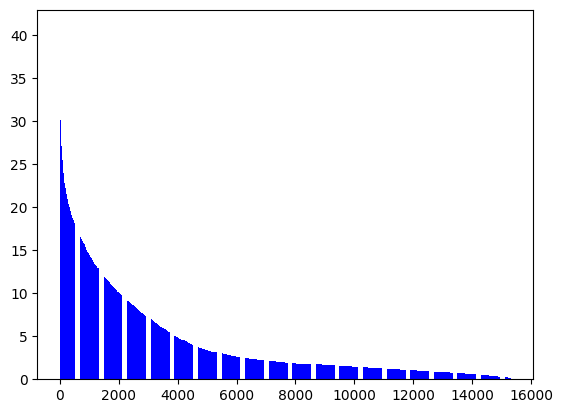

In [15]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indCliente = pd.DataFrame()

indCliente['ctdComer'] = copy.groupby(['customer_id','semana_dates']).size()
indCliente['pctComer'] = round(100*indCliente['ctdComer']/comUn,2)
indCliente = indCliente.sort_values('pctComer', ascending=False)

plt.bar(range(len(indCliente.index)),indCliente['pctComer'],color='blue')
plt.show()

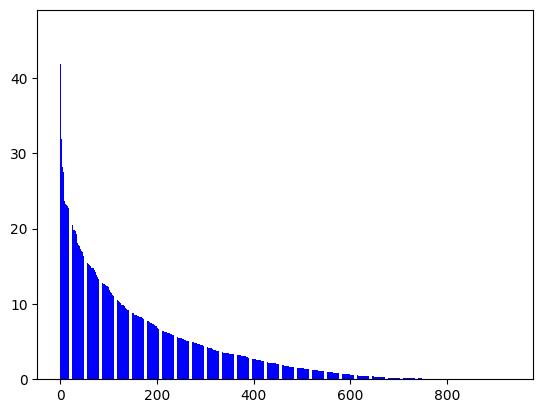

In [16]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indComer = pd.DataFrame()

indComer['ctdCli'] = copy.groupby(['product_id','semana_dates']).size()
indComer['pctCli'] = round(100*indComer['ctdCli']/cliUn,2)
indComer = indComer.sort_values('pctCli', ascending=False)

plt.bar(range(len(indComer.index)),indComer['pctCli'],color='blue')
plt.show()

In [17]:

# Filtro de Clientes:
filCli = indCliente[(indCliente['pctComer']>=0.5)&(indCliente['pctComer']<=18)].reset_index() ##se puede ajustar este acote (0.025), se añade &(indCliente['pctComer']<=0.95)
filCli = filCli['customer_id'].drop_duplicates()
# Filtro de Comercios:
filComer = indComer[(indComer['pctCli']>=0.01)&(indComer['pctCli']<=19)].reset_index() ##se puede ajustar este acote (0.025) , se añade &(indCliente['pctCli']<=0.95)
filComer = filComer['product_id'].drop_duplicates()

print('Clientes únicos: '+str(filCli.shape[0]))
print('Productos únicos: '+str(filComer.shape[0]))

dataBaseInput = dataBaseInputPre[dataBaseInputPre['customer_id'].isin(list(filCli))]
dataBaseInput = dataBaseInput[dataBaseInput['product_id'].isin(list(filComer))]
print('Dimensión del Dataset Final: '+str(dataBaseInput.shape[0])+'\n')
dataBaseInput.head()

Clientes únicos: 14064
Productos únicos: 897
Dimensión del Dataset Final: 382749



,customer_id,product_id,rating_1,rating_2,rating_3,rating_4,rating_5,semana_dates
0,1,8,0.000007,9.564328e-09,0.021343,0.000008,1.409452e-07,semana0
101,1,563,0.001065,2.622436e-05,0.003823,0.001953,2.376379e-04,semana0
102,1,568,0.000594,1.948041e-05,0.003669,0.001035,1.258642e-04,semana0
103,1,569,0.000057,4.145939e-07,0.004250,0.000098,3.255721e-06,semana0
104,1,570,0.000062,4.549213e-07,0.004097,0.000114,3.778840e-06,semana0


In [18]:
# dtf_products=dtf_products[['product_id','family_id','negocio_id','category_id','tier_id']]

# dummies_family = pd.get_dummies(dtf_products['family_id'], prefix='family')
# dummies_negocio = pd.get_dummies(dtf_products['negocio_id'], prefix='negocio')
# dummies_category = pd.get_dummies(dtf_products['category_id'], prefix='category')
# dummies_tier = pd.get_dummies(dtf_products['tier_id'], prefix='tier')

# # Concatenar las columnas binarias con la columna 'product_id'
# tabla_doble_entrada = pd.concat([dtf_products['product_id'], dummies_family, dummies_negocio, dummies_category, dummies_tier], axis=1)

# # Eliminar filas duplicadas para tener un único 'product_id' en la tabla
# tabla_doble_entrada = tabla_doble_entrada.drop_duplicates(subset='product_id', keep='first')

# # Configurar 'product_id' como el índice de la tabla
# dtf_products = tabla_doble_entrada.set_index('product_id')
# dtf_products.head()

## 2 - Preprocessing

In [19]:
dataBaseInput['y']=dataBaseInput['rating_4']
df=dataBaseInput[['customer_id', 'product_id', 'y']].copy()
df=df.drop_duplicates(subset='product_id', keep='first')
dtf_products = df.set_index('product_id')

In [20]:
# Crear una tabla dinámica (pivot table) para obtener la matriz de calificaciones
dtf_users = pd.pivot_table(df, values='y', index='customer_id', columns='product_id')
# Si prefieres que los valores faltantes sean nulos en lugar de ceros, simplemente omite el argumento 'fill_value=0'.
dtf_users.head()

product_id,1,2,3,4,5,6,7,8,9,10,...,927,928,929,930,931,932,933,934,936,937
customer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000008,NaN,NaN,...,NaN,NaN,NaN,0.002835,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product_id,1,2,3,4,5,6,7,8,9,10,...,927,928,929,930,931,932,933,934,936,937
customer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
split = int(0.8*dtf_users.shape[1])
split

708

In [23]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 670


product_id,1,2,3,4,5,6,7,8,9,10,...,698,699,700,701,702,703,704,705,706,707
customer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 215


product_id,708,709,710,711,712,713,714,715,716,717,...,927,928,929,930,931,932,933,934,936,937
customer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3 - Baseline (Content-Based)

In [44]:
dtf_train.iloc[i]

product_id,1,2,3,4,5,6,7,8,9,10,...,698,699,700,701,702,703,704,705,706,707
customer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Select a user
i = 6089
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

IndexError: single positional indexer is out-of-bounds

In [32]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = pd.concat([train, tmp])
train.tail()

,y
product_id,
932,NaN
933,NaN
934,NaN
936,NaN
937,NaN


In [35]:
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 885)  x  Products (885, 2)


In [36]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["y_hat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product_id,y,y_hat
30,738,0.5,848.416094
32,741,0.5,960.339049
79,790,0.5,1785.770945
192,911,0.5,NaN


In [37]:
import tensorflow as tf
# usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = tf.matmul(usr, prd)
# normalize
weights = usr_ft / tf.reduce_sum(usr_ft, axis=1, keepdims=True)
# rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = tf.matmul(weights, prd.T)

In [38]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [40]:
print("--- user", i, "---")

top = 30
y_test = test.sort_values("y", ascending=False)["product_id"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("y_hat", ascending=False)["product_id"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [738 741 790 911]
predicted: [790 741 738 911]
true positive: 4 (13.3%)
accuracy: 50.0%
mrr: 0.52


## 4 - Model Desing & Testing (Collaborative Filtering)